In [1]:
using Pkg
Pkg.activate(".")
using locaTE
using OptimalTransport
using NPZ
using StatsBase
using SparseArrays
using ProgressMeter
using Plots
using NearestNeighbors
using Graphs
using GraphSignals
using Printf
using Base.Threads
using LinearAlgebra
using MultivariateStats
using NNlib
using Discretizers
using EvalMetrics
FIG_DIR = "./"
PLT_CELL = 500
Nq = 500
epfrac = 0.1

include("comparisons/process_outputs_util.jl")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated`


process_genie3 (generic function with 1 method)

In [2]:
DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/BoolODE/Curated/GSD/GSD-1000-2/"
cd(DATA_PATH)

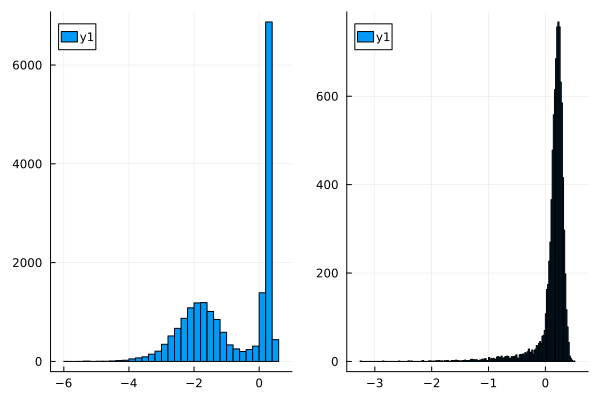

In [3]:
X_raw = npzread("X.npy")
X = relu.(X_raw .- 10^(-0.5));
plot(histogram(log10.(vec(X_raw))), 
    histogram(log10.(vec(X))))

In [4]:
Ng = size(X, 2)
rm_diag(A) = A - Diagonal(diag(A))
preprocess_cespgrn(x) = hcat([vec(rm_diag(reshape(x, Ng, Ng))) for x in eachrow(x)]...)'

preprocess_cespgrn (generic function with 1 method)

In [110]:
X_pca = npzread("X_pca.npy")
X_umap = npzread("X_pca.npy")
P = npzread("P_velo_dot.npy")
J = permutedims(npzread("J.npy"), [1, 3, 2])
C = npzread("C.npy")
dpt = npzread("dpt.npy");

In [111]:
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5*mean(C));

In [112]:
gene_idxs = vcat([[j, i]' for i = 1:size(X, 2) for j = 1:size(X, 2)]...);

In [113]:
k = 3
π_unif = fill(1/size(P, 1), size(P, 1))'
Q = (P' .* π_unif)./(π_unif * P)';
R_sp = sparse(R)
QT_sp = sparse((Q^k)')
P_sp = sparse((P^k));

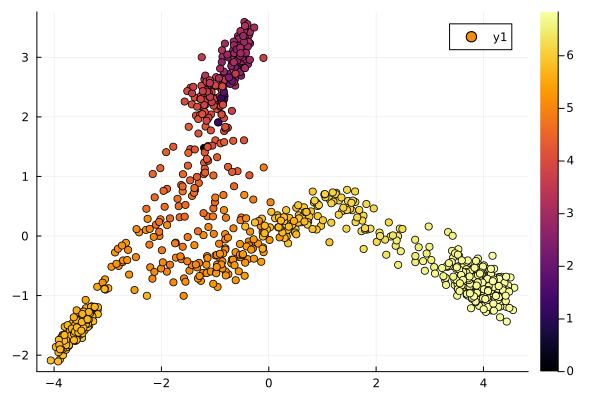

In [114]:
scatter(X_umap[:, 1], X_umap[:, 2], marker_z = log1p.(C[sortperm(dpt)[1], :]))

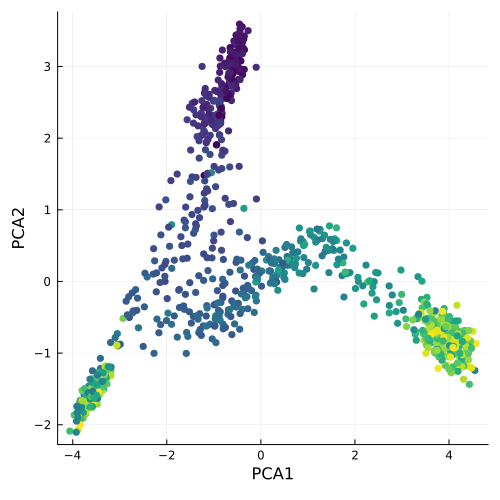

In [115]:
scatter(X_umap[:, 1], X_umap[:, 2], marker_z = dpt, c = :viridis, legend = nothing, colorbar = nothing, markerstrokewidth = 0, xlabel = "PCA1", ylabel = "PCA2", size = (PLT_CELL, PLT_CELL))
# savefig(string(FIG_DIR, "switch_pca.pdf"))

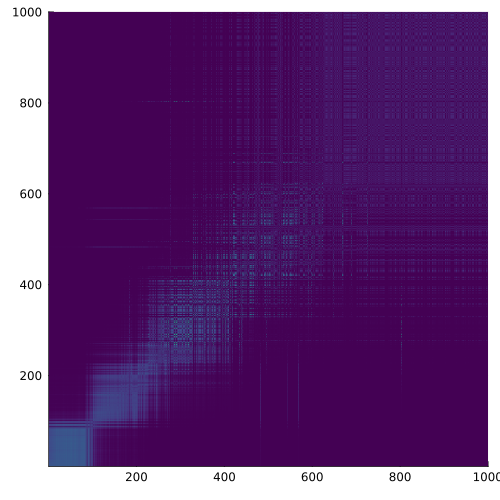

In [116]:
heatmap((R * P * R)[sortperm(dpt), :][:, sortperm(dpt)], 
    clim = (0, quantile(vec(P[P .> 0]), 0.75)), c = :viridis, colorbar = nothing, size = (PLT_CELL, PLT_CELL))
# savefig(string(FIG_DIR, "switch_P.pdf"))

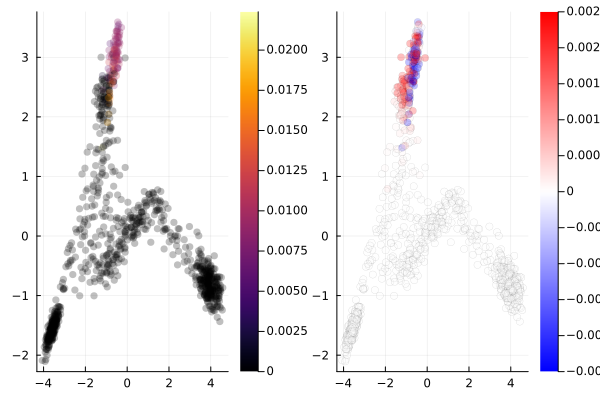

In [117]:
p0 = R[sortperm(dpt)[10], :]
plot(scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = p0, markerstrokewidth = 0, alpha = 0.25), 
    scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = P_sp'*p0 - p0, color = :bwr, clim = (-0.0025, 0.0025), markerstrokewidth = 0.25, alpha = 0.25); legend = nothing)

In [118]:
# construct kNN and Laplacian
kdtree = KDTree(X_pca')
idxs, dists = knn(kdtree, X_pca', 25);
A = spzeros(size(X_pca, 1), size(X_pca, 1));
for (i, j) in enumerate(idxs)
    A[i, j] .= 1.0
end
L = sparse(normalized_laplacian(max.(A, A'), Float64));

In [119]:
TE = estimate_TE(X, 1:size(X, 2), 1:size(X, 2), P_sp, QT_sp, R_sp);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


In [120]:
TE_clr = apply_wclr(TE, size(X, 2))
TE_clr[isnan.(TE_clr)] .= 0;

In [121]:
@info "Denoising"
w = normalize(vec(sqrt.(sum(TE_clr.^2; dims = 2))), 1)
G = fitsp(TE_clr, L; λ1 = 25.0, λ2 = 0.001, maxiter = 250);
# G = locaTE.symm_row(G, size(X, 2));

[ Info: Denoising
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
[ Info: ΔX = 1.5338476171394139e-7, ΔZ = 3.704516996259899e-5, ΔW = 5.32428776178033e-5
[ Info: tr(X'LX) = 0.06471476579052263, 0.5|X-G|^2 = 1.1250646743321635, |X|1 = 265.8627732610182


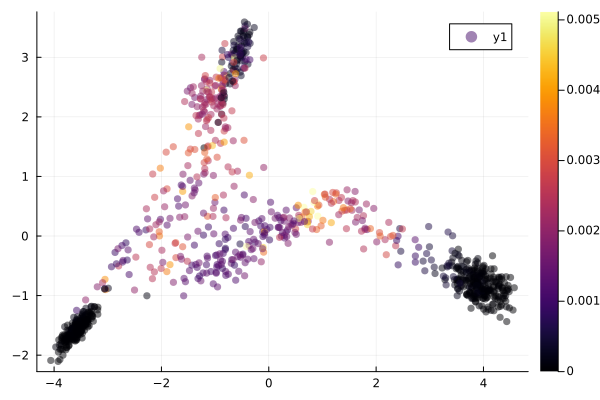

In [122]:
# TE density 
scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = w, markerstrokewidth = 0, clim = (0, quantile(w, 0.995)), alpha = 0.5)

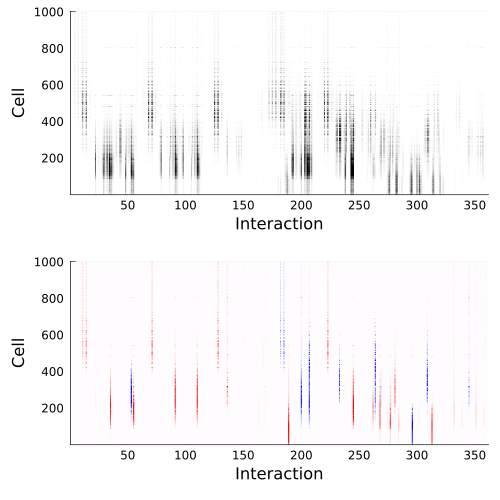

In [123]:
plt=plot(heatmap(G[sortperm(dpt), :]; xlabel = "Interaction", ylabel = "Cell", c = cgrad([:white, :black]), clim = (0, quantile(vec(G), 0.995))), 
    heatmap((R * reshape(J, :, size(X, 2)^2))[sortperm(dpt), :], c = :bwr, clim = (-1.5, 1.5); xlabel = "Interaction", ylabel = "Cell"),
    colorbar = nothing, layout = (2, 1), size = (PLT_CELL,PLT_CELL))
plt

In [124]:
G_symm = locaTE.symm_row(G, size(X, 2))
A = reshape(maximum(G; dims = 1), size(X, 2), size(X, 2))
G_cdf = apply_cdf_norm(G, A .+ 1e-9);
A_symm = reshape(maximum(G_symm; dims = 1), size(X, 2), size(X, 2))
G_symm_cdf = apply_cdf_norm(G_symm, A_symm .+ 1e-9);

In [125]:
J_symm = permutedims(cat([locaTE.symm(x) for x in eachslice(abs.(J); dims = 1)]...; dims = 3), [3, 1, 2])
J_static = (mean(abs.(J); dims = 1)[1, :, :] .> 0.1)*1.0
J_static_symm = locaTE.symm(J_static);
J_thresh = 0.5

0.5

In [126]:
using EvalMetrics
G_static = reshape(mean(G; dims = 1), size(X, 2), size(X, 2))
G_static_cdf = cdf_norm(G_static, G_static)

19×19 Matrix{Float64}:
 0.349292  0.293641  0.298143  0.441466  …  0.284903   0.374858  0.254632
 0.296813  0.241161  0.434289  0.309882     0.251353   0.301905  0.411908
 0.257971  0.860837  0.206822  0.27104      0.480469   0.26581   0.711882
 0.697653  0.286646  0.291148  0.355366     0.277908   0.369461  0.255414
 0.279033  0.344149  0.836603  0.352808     0.951267   0.235742  0.525672
 0.222187  0.384605  0.866825  0.40835   …  0.930612   0.238457  0.548084
 0.73187   0.283567  0.288069  0.402771     0.274829   0.370997  0.25481
 0.287858  0.244085  0.482729  0.300927     0.240555   0.307228  0.205115
 0.269758  0.589887  0.230595  0.288005     0.39128    0.268608  0.294067
 0.457479  0.804574  0.841408  0.318519     0.880111   0.379044  0.429463
 0.924963  0.711875  0.381217  0.942357  …  0.562392   0.48757   0.554952
 0.577024  0.292525  0.297027  0.361263     0.283787   0.37596   0.260983
 0.327316  0.903136  0.501599  0.389691     0.220427   0.261071  0.646454
 0.946847  0.203

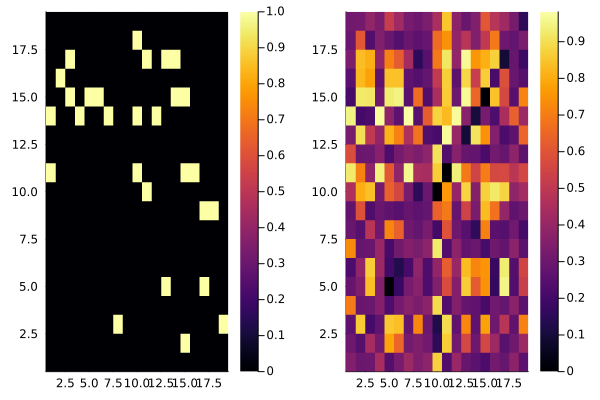

In [127]:
plot(heatmap(J_static), heatmap(G_static_cdf))

┌ Warning: The closest higher feasible true positive rate to some of the required values (0.9665551839464883, 0.9698996655518395, 0.9732441471571907, 0.9765886287625418, 0.979933110367893, 0.9832775919732442, 0.9866220735785953, 0.9899665551839465, 0.9933110367892977, 0.9966555183946488) is 1.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:93
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


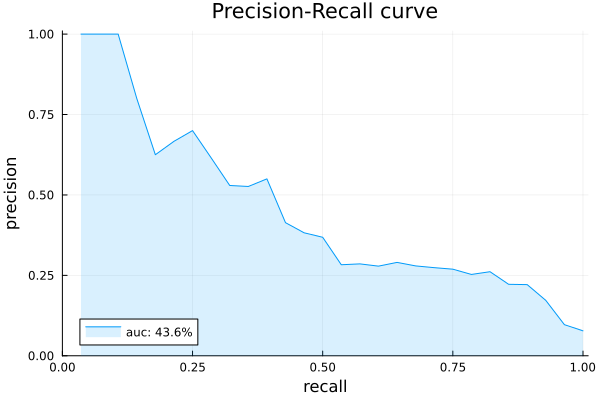

In [128]:
prplot(vec(J_static), vec(G_static_cdf))

In [129]:
au_prcurve(vec(J_static), vec(G_static_cdf)) / mean(J_static)

5.620879278580117

┌ Warning: The closest higher feasible true positive rate to some of the required values (0.9464882943143813, 0.9498327759197325, 0.9531772575250836, 0.9565217391304348, 0.959866220735786, 0.9632107023411371, 0.9665551839464883, 0.9698996655518395, 0.9732441471571907, 0.9765886287625418, 0.979933110367893, 0.9832775919732442, 0.9866220735785953, 0.9899665551839465, 0.9933110367892977, 0.9966555183946488) is 1.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:93
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


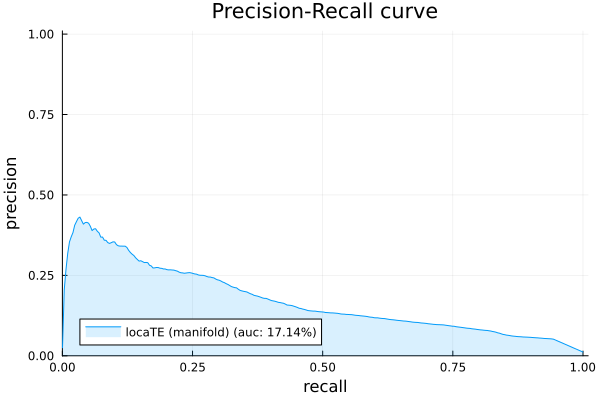

In [130]:
_J = reshape(abs.(J), :, size(X, 2) * size(X, 2))
plt2 = prplot(
    vec(R * _J) .> 0.5,
    vec(G_cdf);
    label = "locaTE (manifold)",
)